In [1]:
import pandas as pd
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow 
import autokeras as ak

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/results/*.txt"))))

In [3]:
df

,curr_dens,Volts_tot,Temp_tot,t_tot,SOC_tot
0,-17.715577,3.728046,272.000000,0.0,34.000000
1,-17.715577,3.727801,272.003044,0.5,33.991582
2,-17.715577,3.727573,272.006279,1.0,33.983165
3,-17.715577,3.727355,272.009530,1.5,33.974747
4,-17.715577,3.727144,272.012796,2.0,33.966330
...,...,...,...,...,...
5543,8.920406,3.406472,317.898041,2771.5,3.757894
5544,23.201588,3.443712,317.888330,2772.0,3.768918
5545,23.201588,3.444352,317.878582,2772.5,3.779942
5546,23.201588,3.444985,317.868878,2773.0,3.790967


In [4]:
X=df.drop(columns=['SOC_tot'])
y = df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=False)

Coefficients: 
 [-2.74050700e-01  1.44108418e+02 -5.41361111e-02  1.24772847e-03]
Mean squared error: 74.29
Coefficient of determination: 0.86


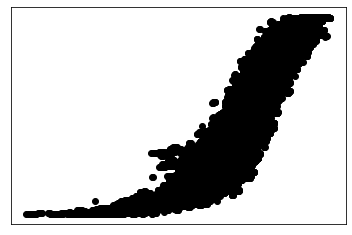

In [5]:
regr = LinearRegression()
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test['Volts_tot'], y_test,  color='black')
#plt.plot(X_test['voltage'], color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [6]:
# It tries 10 different models.
reg = ak.StructuredDataRegressor(max_trials=30, overwrite=True)
# Feed the structured data regressor with training data.
reg.fit(X_train, y_train, epochs=30)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
print(reg.evaluate(X_test, y_test))

Trial 30 Complete [00h 04m 31s]
val_loss: 13.4269437789917

Best val_loss So Far: 9.719265937805176
Total elapsed time: 06h 05m 01s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
11649/11649 [==============================] - 16s 1ms/step - loss: 933.3792 - mean_squared_error: 933.3792 1s - loss:
Epoch 2/30
11649/11649 [==============================] - 15s 1ms/step - loss: 148.0320 - mean_squared_error: 148.0320
Epoch 3/30
11649/11649 [==============================] - 15s 1ms/step - loss: 139.9503 - mean_squared_error: 139.9503
Epoch 4/30
11649/11649 [==============================] - 19s 2ms/step - loss: 142.5530 - mean_squared_error: 142.5530
Epoch 5/30
11649/11649 [==============================] - 19s 2ms/step - loss: 137.5910 - mean_squared_error: 137.5910 9s - los - ETA: 7s - l - ETA: 3s - loss: 129.3529 - mean_s - ETA: 0s - loss: 138.9315 - mean_squared_error
Epoch 6/30
11649/11649 [==============================] - 16s 1ms/step - loss: 136.6478 - mean_squared_error: 136.647

2021-10-03 22:49:58.889881: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets
4993/4993 [==============================] - 5s 915us/step - loss: 14.0111 - mean_squared_error: 14.01110s - loss: 15.0526 - - ETA: 0s - loss: 14.4583 - mean_squared_error:
[14.011148452758789, 14.011148452758789]


In [7]:
model1 = reg.export_model()

In [8]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 4)                 0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056  

In [9]:
model1.save("model_autokeras_temp", save_format="tf")

INFO:tensorflow:Assets written to: model_autokeras_temp/assets


In [11]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model_autokeras_temp", custom_objects=ak.CUSTOM_OBJECTS)

In [12]:
predicted_y = loaded_model.predict(tf.expand_dims(X_test, -1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

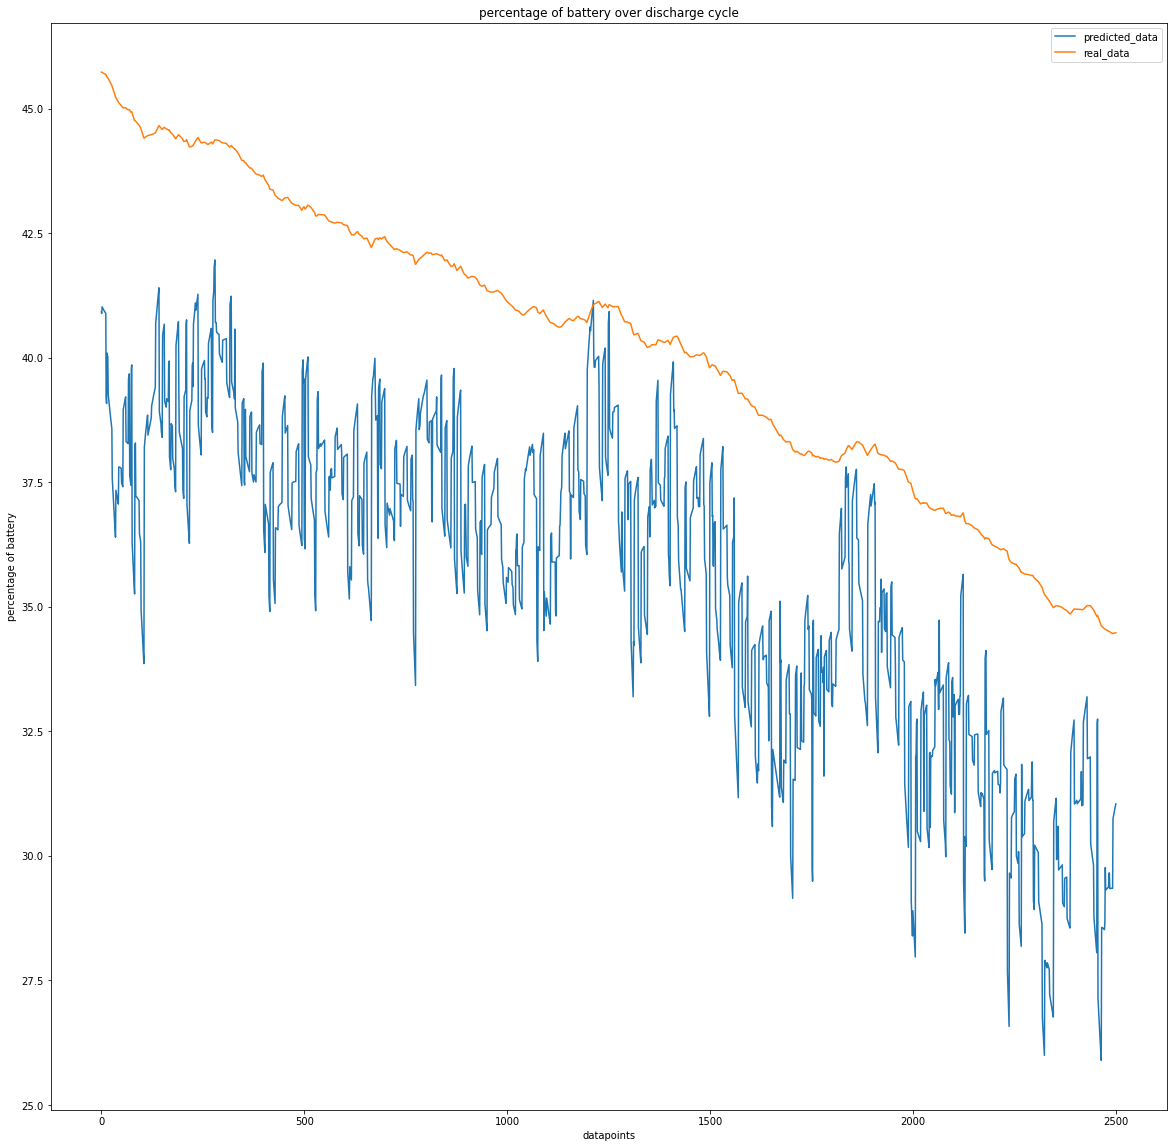

In [15]:
X = np.linspace(0,2500,2500)
plt.figure(figsize=(20,20))
plt.plot(X,predicted_y[0:2500], label='predicted_data')
plt.plot(X,y_test[0:2500], label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()